# Mandelbrot Set

Loading in from packages

In [1]:
# Import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import time

# Trange for tracking ciomputations
from tqdm import trange
from tqdm import tqdm

# Toolkits for drawing figures
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

Settings for the notebook

In [2]:
create_baseline = False

Class for the mandelbrot set, leading for the entire notebook

In [3]:
import numpy as np
import pickle

class MandelBrot():

    """
    Class which helps creating a standard grid on which a mandelbrot can be
    sampled. It consists of methods for creating a full mandelbrot, which has 
    the sole purpose of drawing images, and multiple sampling methods for the
    grid.
    """

    def __init__(self, create_full=False, load=False, max_iterations=100, X=(-2, 1), Y=(-1.5, 1.5), MaxSampleSize=1024):

        """
        Initilization of the class.

        args:
            create_full:    (Bool)  Set to true if image has to be drawn
            load:           (Bool)  Set to true if mandelbrotdata has to be read from memory
            max_iterations: (Int)   Maximum iterations for the full mandelbrot
            X:              (Tuple) Min and max of the grid
            Y:              (Tuple) Min and max of the grid
            MaxSampleSize:  (Int)   Decisive for the amount of grid blocks on the X and Y axis

        returns:
            MandelbrotSet   (Class)
        """

        self.sharpness = (X[1] - X[0])/ MaxSampleSize
        self.X_grid = np.arange(X[0], X[1], self.sharpness)
        self.Y_grid = np.arange(Y[0], Y[1], self.sharpness)
        self.grid_size = (len(self.X_grid), len(self.Y_grid))
        self.max_iterations = max_iterations
        self.area_size = (X[1] - X[0]) * (Y[1] - Y[0])

        self.MaxSampleSize = len(self.X_grid)
        
        if create_full == True:
            self._create_MandelBrot()
        elif load == True:
            self._load_Mandelbrot()

    def _iterate(self, complex_number, max_iterations):
        """
        Method to iterate using complex numbers;
        
        args:
            complex_number: (Complex) Complex number
            max_iterations: (Int)     Max iterations to check for convergence
        
        returns:
            interations:    (Int)     Amount of iterations done for divergence
        """
        zn = 0
        for i in range(max_iterations):
            if abs(zn) > 2:
                break
            zn = zn**2 + complex_number
        return i + 1

    def _create_MandelBrot(self, save=True):
        """ 
        Method for creating full mandelbrotset with as purpose drawing a fig.

        args:
            save:   (Bool)  Boolean to save the created class as a pickle object
        """
        self.Z = np.zeros(self.grid_size)
        for i in range(np.shape(self.Z)[0]):
            for j in range(np.shape(self.Z)[1]):
                # print(x, i, y, j)
                complex_number = complex(self.X_grid[i], self.Y_grid[j])
                iters = self._iterate(complex_number, self.max_iterations)
                self.Z[j][i] = 1 - iters/self.max_iterations
        
        if save:
            dbfile = open('mandelbrotdata_class', 'wb')
            pickle.dump(self.Z, dbfile)                     
            dbfile.close()
    
    def _load_Mandelbrot(self):
        """ 
        Method for loading data from a pickle object. 
        """
        infile = open("mandelbrotdata",'rb')
        self.Z = pickle.load(infile)
        self.X_grid, self.Y_grid = np.shape(self.Z)
        infile.close()

    def RANDOM_SAMPLE(self, N):
        """ 
        Method to RANDOM sample the created grid. 

        args:
            N:      (Int)   Amount to be sampled.
        returns:
            samples (Tuple) A tuple of N * X samples and N * Y samples. 
                            Being a total of N coordinates.
        """
        # No more samples than the grid divided spaces can be taken
        if N > self.MaxSampleSize:
            print(f'Sample size to big! Should be lower than {self.MaxSampleSize}')
            return
        else:
            return (
                np.random.choice(self.X_grid, size=N, replace=True),
                np.random.choice(self.Y_grid, size=N, replace=True)
            )

    def RANDOM_SAMPLE_ISS(self, x, y, N, LHC=False):
        """ 
        Method to RANDOM sample the created grid, specifically for Intelligent Stratfied
        Sampling.

        args:
            x:      (1D array) Array with possible x values to sample from.
            y:      (1D array) Array with possible y values to sample from.
            N:      (Int)      Amount to be sampled.
            LHC:    (Bool)     Whether Latin Hypercube Sampling is used.
            
        returns:
            samples (Tuple) A tuple of N * x samples and N * y samples. 
                            Being a total of N coordinates.
        """
        # No more samples than the grid divided spaces can be taken
        if N > self.MaxSampleSize:
            print(f'Sample size to big! Should be lower than {self.MaxSampleSize}')
            return
        else:
            
            # indexes of all samples
            choicelist = list(range(len(x)))
            
            # combine x and y arrays
            X = np.column_stack((x,y))
            
            # get indices of all sampled datapoints
            inds = np.random.choice(choicelist, size=s, replace=not(LHC))
            
            # obtain chosen samples
            X = X[inds]
            new_x = X[:,0]
            new_y = X[:,1]
            
            return [new_x, new_y]


    
    def LHC_SAMPLE(self, N):
        """ 
        Method to Latin Hyper Cube (LHC) sample the created grid. 

        args:
            N:      (Int)   Amount to be sampled.
        returns:
            samples (Tuple) A tuple of N * X samples and N * Y samples. 
                            Being a total of N coordinates.
        """
        # No more samples than the grid divided spaces can be taken
        if N > self.MaxSampleSize:
            print(f'Sample size to big! Should be lower than {self.MaxSampleSize}')
            return
        else:
            return (
                np.random.choice(self.X_grid, size=N, replace=False),
                np.random.choice(self.Y_grid, size=N, replace=False)
            )

    def ORTHOGONAL_SAMPLE(self, N, grid_divide=4):
        """ 
        Method to ORTHOGONAL sample the created grid. 

        args:
            N:              (Int)   Amount to be sampled.
            grid_divide:    (Int)   The amount of spaces the X and Y 
                                    grid has to be divided in. Total 
                                    amount of squares is grid_divide**2
        returns:
            samples:        (Tuple) A tuple of N * X samples and N * Y samples. 
                                    Being a total of N coordinates.
        """
        # No more samples than the grid divided spaces can be taken
        if N > self.MaxSampleSize:
            print(f'Sample size to big! Should be lower than {self.MaxSampleSize}')
            return
        else:
            # Create divisions for x and y axis.
            stepsize = int(len(self.X_grid)/grid_divide)
            self.stepsize = stepsize
            x_choices, y_choices = [], []

            # Create arrays that keep track of the columns and rows that are already selected
            x_masked, y_masked = np.ones(len(self.X_grid), dtype='bool'), np.ones(len(self.Y_grid), dtype='bool')

            counter = 0
            # While there are still possible samples left
            while ((np.any(x_masked) == True) & 
                   (np.any(y_masked) == True)):
                # if counter > 10:
                #     print(x_masked, y_masked)
                #     print(x_choices, 'X') 
                #     print(y_choices, 'Y')
                #     return

                counter+=1  
                for i_y in range(0, len(x_masked), stepsize):
                    for i_x in range(0, len(x_masked), stepsize):

                        try:
                            x_choice = np.random.choice(np.arange(i_x, i_x + stepsize, 1)[x_masked[i_x: i_x + stepsize]])
                            y_choice = np.random.choice(np.arange(i_y, i_y + stepsize, 1)[y_masked[i_y: i_y + stepsize]])

                            x_masked[x_choice] = False
                            x_choices.append(x_choice)

                            y_masked[y_choice] = False
                            y_choices.append(y_choice)
                        except:
                            pass

                        # Break out inner for loop when choices surpass desired sample size
                        if len(x_choices) >= N:
                            break
                    # Break from middle for loop when choices surpass desired sample size
                    if len(x_choices) >= N:
                            break
                
                # Break out outer for loop when choices surpass desired sample size
                if len(x_choices) >= N:
                            break

            return self.X_grid[x_choices], self.Y_grid[y_choices]



# Monte Carlo Method

In [4]:
def monte_carlo(samples, max_iterations, mandelbrot):
    """
    Performs the monte carlo simulation.

    args:
        samples:        (Int)   Total N samples given to check for convergence
        max_iterations: (Int)   Maximum amount of iterations to check for convergence
        mandelbrot:     (Class) Mandelbrot set as created in the MandelBrot Class
      
    returns:
        area_estimation (Float) Estimation of the mandelbrot area
    """

    # counters
    Inner = 0
    
    for i in range(len(samples[0])):
        iters = mandelbrot._iterate(complex(samples[0][i], samples[1][i]), max_iterations)
        if iters >= max_iterations:
            Inner += 1

    return  mandelbrot.area_size * (Inner/ len(samples[0]))

In [5]:
def calc_error(estimation, baseline=1.510995):
    """ 
    Method to calculate error based on the baseline

    args:
        estimation: (Float) Estimation of the mandelbrotset
        baseline:   (Float) Baseline as calculated in the previous methods
    """
    return abs(estimation - baseline)
    
def estimate_area(mandelbrotset, samplesize, iterations, minimal_runs=30, method='random'):
    """
    Method to estimate area for a samplesize, iteration and runs.

    args:
        mandelbrotset   (Class)         Mandelbrotset class as created above
        samplesize      (Int)           Amount of samples
        iterations:     (Int)           Iterations done to check for convergence
        minimal_runs    (Int)           N of runs to calculate mean and variance of the samplesize 
                                        and iterations given
        method:         (Class Method)  Class method which is responsible for the sampling method

    returns:
        MeanEstimation: (Float)         Mean of all estimations done for the given samplesize 
                                        and iterations
        MeanError:      (Float)         Mean of all errors done 
        variance:       (Float)         Variance of the estimations
        stdev:          (Float)         Standard deviationf of the estimations
    """
    AllEstimations, AllErrors = [], []
    counter, stdev, d = 1, 100, 1.96
    while ((counter <= minimal_runs) |
          ((stdev/np.sqrt(counter)) > d)):

        if method.lower() == 'random':
            samples = mandelbrotset.RANDOM_SAMPLE(N=samplesize)
        elif method.lower() == 'lhc':
            samples = mandelbrotset.LHC_SAMPLE(N=samplesize)
        elif method.lower() == 'orthogonal':
            samples = mandelbrotset.ORTHOGONAL_SAMPLE(N=samplesize)
        else:
            print('No known method selected.\nPerforms random sampling.')
            samples = mandelbrotset.RANDOM_SAMPLE(N=samplesize)

        area_estimation = monte_carlo(samples, iterations, mandelbrotset)
        error = calc_error(area_estimation)

        AllEstimations.append(area_estimation), AllErrors.append(error)

        if counter > 1:
            variance = np.var(AllEstimations, ddof=1)
            stdev = np.sqrt(variance)

        if counter > 100:
            print('Calculation not finished within confidence interval of 95%\n')
            break

        counter += 1

    return [np.mean(AllEstimations), np.mean(AllErrors), variance, stdev]

def estimate_area_boxplot(mandelbrotset, samplesize, iterations, runs, method='random'):
    """
    Method to estimate area for a samplesize, iteration and runs for the purpose 
    of creating the boxplots.

    args:
        mandelbrotset   (Class)         Mandelbrotset class as created above
        samplesize      (Int)           Amount of samples
        iterations:     (Int)           Iterations done to check for convergence
        runs            (Int)           Runs
        method:         (Class Method)  Class method which is responsible for the sampling method

    returns:
        MeanEstimation: (Float)         Mean of all estimations done for the given samplesize 
                                        and iterations
        MeanError:      (Float)         Mean of all errors done 
    """
    AllEstimations, AllErrors, AllMethods = [], [], []

    for _ in trange(runs):

        if method.lower() == 'random':
            samples = mandelbrotset.RANDOM_SAMPLE(N=samplesize)
        elif method.lower() == 'lhc':
            samples = mandelbrotset.LHC_SAMPLE(N=samplesize)
        elif method.lower() == 'orthogonal':
            if samplesize == 3025:
                samples = mandelbrotset.ORTHOGONAL_SAMPLE(N=samplesize, grid_divide=5)
            else:
                samples = mandelbrotset.ORTHOGONAL_SAMPLE(N=samplesize)
        elif method.lower() == 'orthogonal+':
            samples = mandelbrotset.ORTHOGONAL_SAMPLE(N=samplesize, grid_divide=np.sqrt(samplesize))
        else:
            print('No known method selected.\nPerforms random sampling.')
            samples = mandelbrotset.RANDOM_SAMPLE(N=samplesize)

        area_estimation = monte_carlo(samples, iterations, mandelbrotset)
        error = calc_error(area_estimation)

        AllEstimations.append(area_estimation), AllErrors.append(error), AllMethods.append(method)

    return (AllEstimations, AllErrors, AllMethods)

# Creation of baseline

In [6]:

if create_baseline == True:
    # Create Baseline predictions
    BASE_MANDELBROT = MandelBrot(X=(-2, 1), Y=(-1.5, 1.5), MaxSampleSize=1e5)

    # Create empty lists to save estimations
    random_ests, lhc_ests, orthogonal_ests = [], [], []

    # Create 30 samples
    print('Baseline loop starting..')
    for i in trange(30):

        # Remove output to check progress
        clear_output(wait=True)

        # random_ests.append(monte_carlo(BASE_MANDELBROT.RANDOM_SAMPLE(int(1e5)), 1000, BASE_MANDELBROT))
        # lhc_ests.append(monte_carlo(BASE_MANDELBROT.LHC_SAMPLE(int(1e5)), 1000, BASE_MANDELBROT))
        orthogonal_ests.append(monte_carlo(BASE_MANDELBROT.ORTHOGONAL_SAMPLE(int(1e5)), 1000, BASE_MANDELBROT))

        print('Current progress: ', np.round(((i+1)/30)*100, 2), "%")

    # Save the baselines
    baselines = {
        'Random': np.mean(random_ests),
        'LHC': np.mean(lhc_ests),
        'Orthogonal': np.mean(orthogonal_ests)
    }

    # remove garbage list to save memory
    del random_ests
    del lhc_ests
    del orthogonal_ests


In [7]:
# # Save baselines
# dbfile = open('baselines', 'wb')
# pickle.dump(baselines, dbfile)                     
# dbfile.close()

In [8]:
# # Load baselines
# infile = open('baselines', 'rb')
# baseline = pickle.load(infile)['Orthogonal']
# infile.close()
# del infile

# All experiments

In [21]:
# Create the grid from wich the values will be sampled.
MyMandelbrot = MandelBrot(
    create_full=False,
    load=False,  
    MaxSampleSize=3e4
)
print('Gridsize_X: ' f'{np.min(MyMandelbrot.X_grid)}, {np.max(MyMandelbrot.X_grid)}')
print('Gridsize_Y: ' f'{np.min(MyMandelbrot.Y_grid)}, {np.max(MyMandelbrot.Y_grid)}')
print('Sharpness: ', MyMandelbrot.sharpness)
print('Gridsize: ', MyMandelbrot.grid_size)

# Create empty values for saving output
output = []
methods = ['Random', 'LHC', 'Orthogonal']
n_samples = np.arange(1, 1001, 1)
n_iterations = np.arange(1, 301, 1)

# Save the fixed values for testing
GIVEN_ITER = 100
GIVEN_SAMPLESIZE = 1000

# Create output for multiple samplesizes
print('Looping over samplesizes...')
for i in trange(len(n_samples)):
    for method in methods:
        row = estimate_area(MyMandelbrot, 
                            samplesize=n_samples[i], 
                            iterations=GIVEN_ITER,
                            method=method)
        row.extend([n_samples[i], GIVEN_ITER, method])
        output.append(row)

# Save to dataframe
df_samplesizes = pd.DataFrame(output, columns=['AreaEstimation', 'Error', 'Variance', 'StDev',
                                               'SampleSize', 'N_iterations', 'Method'])

# Create output for multiple iterations
output = []
print("Looping over iterations possibilities...")
for i in trange(len(n_iterations)):
    for method in methods:
        row = estimate_area(MyMandelbrot,
                            samplesize=GIVEN_SAMPLESIZE, 
                            iterations=n_iterations[i], 
                            method=method)
        row.extend([GIVEN_SAMPLESIZE, n_iterations[i], method])
        output.append(row)

# Save to dataframe
df_iterations = pd.DataFrame(output, columns=['AreaEstimation', 'Error', 'Variance', 'StDev',
                                              'SampleSize', 'N_iterations', 'Method'])


del output
    

Gridsize_X: -2.0, 0.9998999999996698
Gridsize_Y: -1.5, 1.4998999999996698
Sharpness:  0.0001
Gridsize:  (30000, 30000)
Looping over samplesizes...


 92%|█████████▏| 918/1000 [16:51<02:50,  2.09s/it]

In [10]:
# Create grid for valeus
MyMandelbrot = MandelBrot(
    create_full=False,
    load=False,  
    MaxSampleSize=3025
)
print('Gridsize_X: ' f'{np.min(MyMandelbrot.X_grid)}, {np.max(MyMandelbrot.X_grid)}')
print('Gridsize_Y: ' f'{np.min(MyMandelbrot.Y_grid)}, {np.max(MyMandelbrot.Y_grid)}')
print('Sharpness: ', MyMandelbrot.sharpness)
print('Gridsize: ', MyMandelbrot.grid_size)

# Give the samplesize and the iterations
SAMPLESIZE = 3025
N_ITERATIONS = 100

AllEstimations, AllErrors, AllMethods = [], [], []
methods = ['random', 'LHC', 'orthogonal', 'orthogonal+']
# methods = ['orthogonal', 'orthogonal+']

# Loop over methods and perform 10.000 tests
for method in methods:
    print(f"Looping for {method} sampling...")
    output = estimate_area_boxplot(MyMandelbrot, 
                                samplesize=SAMPLESIZE, 
                                iterations=N_ITERATIONS, # dan moet je hiervan n_iterations[i] maken 
                                method=method, 
                                runs=1000)
    AllEstimations.extend(output[0]) 
    AllErrors.extend(output[1])
    AllMethods.extend(output[2])
        
# Save data
df_boxplot = pd.DataFrame()
df_boxplot['AreaEstimation'] = AllEstimations
df_boxplot['Error'] = AllErrors
df_boxplot['Method'] = AllMethods
df_boxplot


Gridsize_X: -2.0, 0.9990082644625851
Gridsize_Y: -1.5, 1.499008264462585
Sharpness:  0.0009917355371900827
Gridsize:  (3025, 3025)
Looping for random sampling...


100%|██████████| 1000/1000 [00:21<00:00, 46.96it/s]


Looping for LHC sampling...


100%|██████████| 1000/1000 [00:20<00:00, 49.50it/s]


Looping for orthogonal sampling...


100%|██████████| 1000/1000 [02:13<00:00,  7.52it/s]


Looping for orthogonal+ sampling...


100%|██████████| 1000/1000 [01:51<00:00,  9.01it/s]


,AreaEstimation,Error,Method
0,1.460826,0.050169,random
1,1.570909,0.059914,random
2,1.425124,0.085871,random
3,1.475702,0.035293,random
4,1.576860,0.065865,random
...,...,...,...
3995,1.544132,0.033137,orthogonal+
3996,1.532231,0.021236,orthogonal+
3997,1.532231,0.021236,orthogonal+
3998,1.538182,0.027187,orthogonal+


In [11]:
# Some code was ran on other computer, so load in
infile = open('new_grid_data_1637590099.620807', 'rb')
_ = pickle.load(infile)
infile.close()
np.shape(_[0])

(1000,)

In [12]:
# Create df for boxplots
new_df = pd.DataFrame()
for method in np.unique(df_boxplot['Method']):
    new_df[method] = df_boxplot.loc[df_boxplot['Method'] == method]['AreaEstimation'].to_list()

new_df['intelligent random'] = _[1]
new_df['intelligent LHC'] = _[3]

# Figures and statistics

Text(0.5, 0.98, 'Area estimation for the different sampling methods')

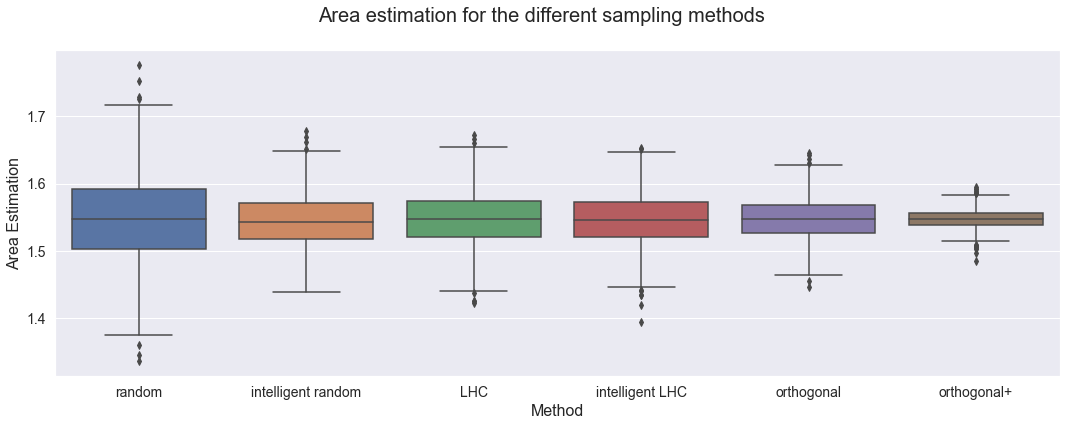

In [13]:
import seaborn as sns

sns.set(style='darkgrid')

fig, axis = plt.subplots(1, 1, figsize=(18, 6))
sns.boxplot(data=new_df, order=['random', 'intelligent random', 'LHC', 'intelligent LHC', 'orthogonal', 'orthogonal+'])
axis.tick_params('both', labelsize=14)
axis.set_xlabel('Method', fontsize=16)
axis.set_ylabel('Area Estimation', fontsize=16)
fig.suptitle('Area estimation for the different sampling methods', fontsize=20)


In [15]:
# perform levene test for all possible combinations

from scipy.stats import levene

methods = new_df.columns
for method in methods:
       for method2 in methods:
              print(levene(new_df[method], new_df[method2]))
       methods = np.delete(methods, np.argwhere(methods == method))

LeveneResult(statistic=0.0, pvalue=1.0)
LeveneResult(statistic=80.00481470637426, pvalue=8.30950718455283e-19)
LeveneResult(statistic=694.1943139867825, pvalue=1.4583777737770023e-131)
LeveneResult(statistic=145.2597820632107, pvalue=2.4225022558767248e-32)
LeveneResult(statistic=7.206051035378085, pvalue=0.007325837325016271)
LeveneResult(statistic=9.668746027210455, pvalue=0.001900730749862832)
LeveneResult(statistic=0.0, pvalue=1.0)
LeveneResult(statistic=426.2440280483534, pvalue=5.384747254654166e-86)
LeveneResult(statistic=393.59616384710347, pvalue=4.2465788879870685e-80)
LeveneResult(statistic=41.24813112883293, pvalue=1.6709333886282624e-10)
LeveneResult(statistic=34.940969852106555, pvalue=3.98650995125005e-09)
LeveneResult(statistic=0.0, pvalue=1.0)
LeveneResult(statistic=1075.7146192990729, pvalue=3.9644052503623136e-189)
LeveneResult(statistic=628.2998835836705, pvalue=8.539002360059279e-121)
LeveneResult(statistic=594.6752564201234, pvalue=3.3971063750531856e-115)
LeveneR

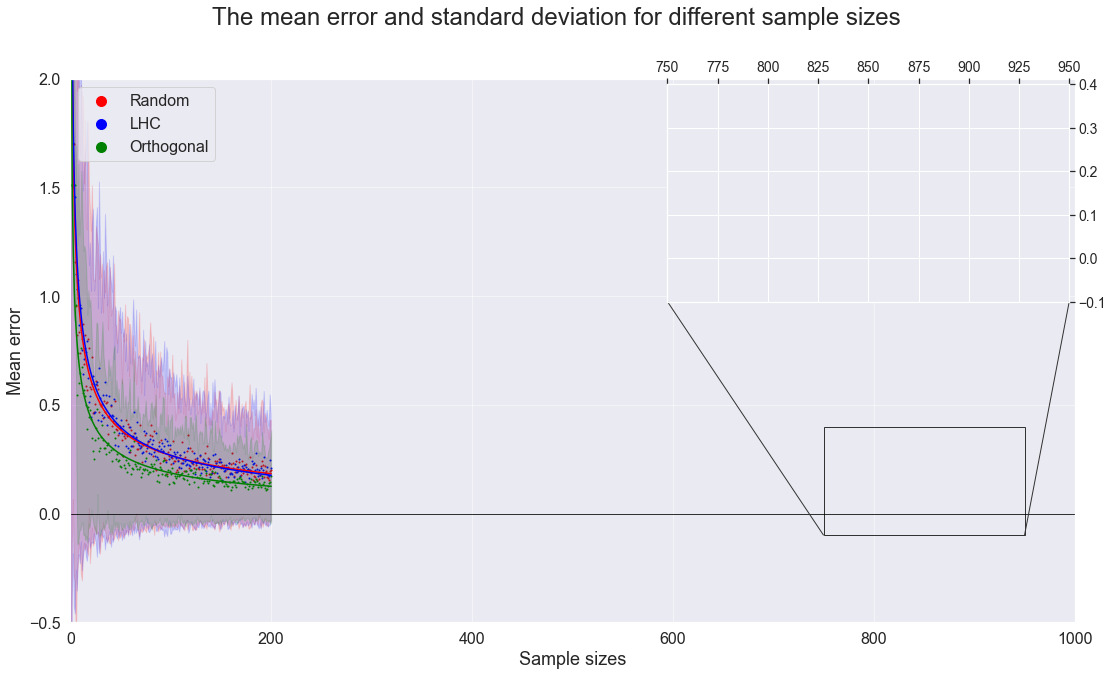

In [16]:
from scipy.optimize import curve_fit

# Functions for fitting line
def func(x, a, b, c):
    return a * -b * np.sqrt(x) /  x - c

def fit_curve(df, name):
    popt, pcov = curve_fit(func, df[name], df['Error'])
    return popt

# Draw figure for report
def draw_simple_figure(df, what='samplesizes'):
    if what == 'samplesizes':
        name = 'SampleSize'
    else:
        name = 'N_iterations'
    
    methods = ['Random', 'LHC', 'Orthogonal']
    colors = ['red', 'blue', 'green']


    fig, ax = plt.subplots(figsize=(18, 10))
    
    # set limits of figure
    ax.set_xlim(0,1000)
    ax.set_ylim(-.5, 2)
    ax.hlines(0, 0, 1000, color='black', linewidth=0.8)

    # Zoom in on interesting part
    axins = zoomed_inset_axes(ax, 2, loc=1)
    axins.hlines(0, 0, 200, color='black', linewidth=0.5)

    # plot all points
    for i in range(len(methods)):
        _ = df.loc[df['Method'] == methods[i]]
        if name == 'SampleSize':
            popt = fit_curve(_, name)
            ax.plot(_[name], func(_[name], *popt), c=colors[i])
        ax.scatter(_[name], _['Error'], s=1, c=colors[i], label=methods[i])
        ax.fill_between(_[name], _['Error'] + _['StDev'], y2=_['Error'] - _['StDev'], alpha=0.15, color=colors[i])

        axins.scatter(_[name], _['Error'], s=10, c=colors[i])
        axins.fill_between(_[name], _['Error'] + _['StDev'], y2=_['Error'] - _['StDev'], alpha=0.15, color=colors[i])
        axins.plot(_[name], func(_[name], *popt), c=colors[i])

    # set limits
    axins.set_xlim(750, 950)
    axins.set_ylim(-0.1, 0.4)

    # Change tick params
    axins.tick_params(axis='x', 
                    which='both', 
                    bottom=False, 
                    top=True, 
                    labelbottom=False, 
                    labeltop=True)
    axins.tick_params(axis='y', 
                    which='both', 
                    left=False,
                    right=True, 
                    top=False, 
                    labelright=True, 
                    labelleft=False)

    # Draw the zooming lines
    mark_inset(ax, axins, loc1=3, loc2=4, fc='none', ec='0.2')

    # Change tick parkams
    ax.tick_params('both', labelsize=16)
    axins.tick_params('both', labelsize=14)

    # give the figure his grid and legend
    ax.legend(loc=2, fontsize=16, markerscale=10)
    ax.grid(alpha=0.5)

    # Labels
    ax.set_xlabel('Sample sizes', fontsize=18)
    ax.set_ylabel('Mean error', fontsize=18)

    # set title
    plt.suptitle('The mean error and standard deviation for different sample sizes', fontsize=24)
    plt.show()

draw_simple_figure(df_samplesizes, what='samplesizes')

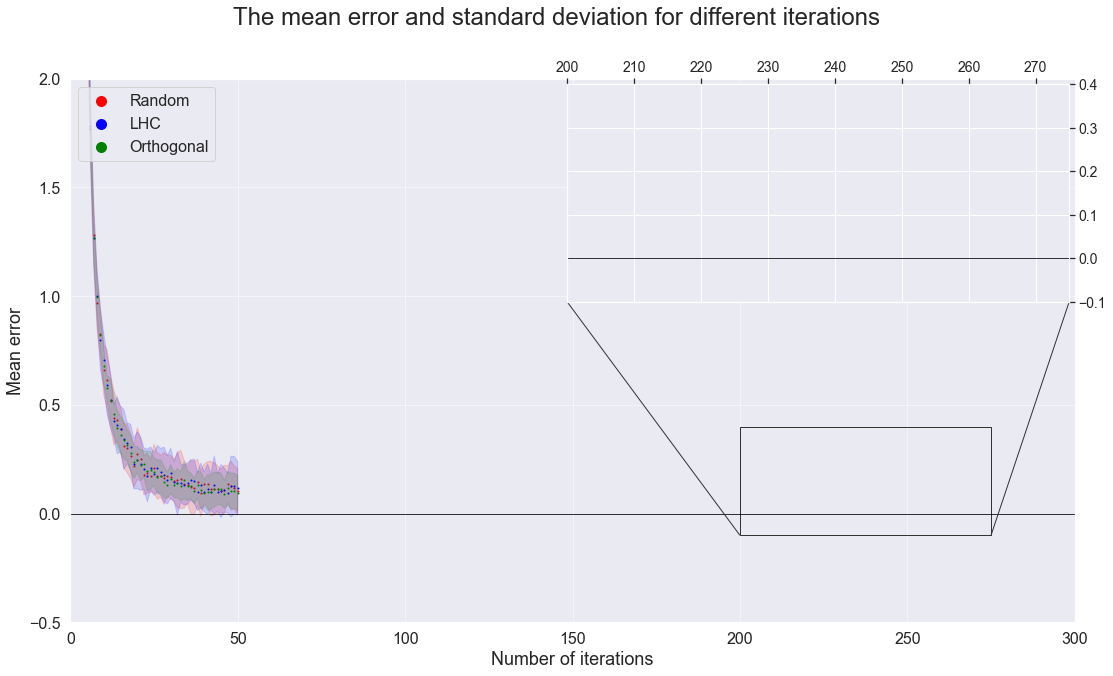

In [17]:
from scipy.optimize import curve_fit

# Function for drwaing figure with zoomed in version
def draw_simple_figure(df, what='samplesizes'):
    if what == 'samplesizes':
        name = 'SampleSize'
    else:
        name = 'N_iterations'
    
    methods = ['Random', 'LHC', 'Orthogonal']
    colors = ['red', 'blue', 'green']


    fig, ax = plt.subplots(figsize=(18, 10))
    
    # set limits of figure
    ax.set_xlim(0,300)
    ax.set_ylim(-.5, 2)
    ax.hlines(0, 0, 300, color='black', linewidth=0.8)

    # Zoom in on interesting part
    axins = zoomed_inset_axes(ax, 2, loc=1)
    axins.hlines(0, 200, 275, color='black', linewidth=0.8)
    
    # Plot all points
    for i in range(len(methods)):
        _ = df.loc[df['Method'] == methods[i]]
        if name == 'samplesizes':
            popt = fit_curve(_, name)
            ax.plot(_[name], func(_[name], *popt), c=colors[i])
            axins.plot(_[name], func(_[name], *popt), c=colors[i])
        ax.scatter(_[name], _['Error'], s=1, c=colors[i], label=methods[i])
        ax.fill_between(_[name], _['Error'] + _['StDev'], y2=_['Error'] - _['StDev'], alpha=0.15, color=colors[i])

        axins.scatter(_[name], _['Error'], s=10, c=colors[i])
        axins.fill_between(_[name], _['Error'] + _['StDev'], y2=_['Error'] - _['StDev'], alpha=0.15, color=colors[i])

    # Set limits  
    axins.set_xlim(200, 275)
    axins.set_ylim(-0.1, 0.4)

    # Change tick params
    axins.tick_params(axis='x', 
                    which='both', 
                    bottom=False, 
                    top=True, 
                    labelbottom=False, 
                    labeltop=True)
    axins.tick_params(axis='y', 
                    which='both', 
                    left=False,
                    right=True, 
                    top=False, 
                    labelright=True, 
                    labelleft=False)

    # Draw lines for zooming
    mark_inset(ax, axins, loc1=3, loc2=4, fc='none', ec='0.2')

    # Change tick params
    ax.tick_params('both', labelsize=16)
    axins.tick_params('both', labelsize=14)

    # give the figure his grid and legend
    ax.legend(loc=2, fontsize=16, markerscale=10)
    ax.grid(alpha=0.5)

    # Labels
    ax.set_xlabel('Number of iterations', fontsize=18)
    ax.set_ylabel('Mean error', fontsize=18)

    # Set title
    plt.suptitle('The mean error and standard deviation for different iterations', fontsize=24)
    plt.show()

draw_simple_figure(df_iterations, what='N_iterations')

36
x_choices:  [ 2  6 16 18 26 34  3  8 12 23 24 33  1  7 13 21 27 30  0 11 17 19 28 32
  5  9 14 20 25 31  4 10 15 22 29 35]
y_choices:  [ 3  5  1  2  0  4  9  8 11  7 10  6 17 14 15 16 13 12 23 21 19 22 20 18
 25 28 24 29 26 27 32 35 30 31 34 33]


Text(0.5, 0.98, 'Multiple sampling methods')

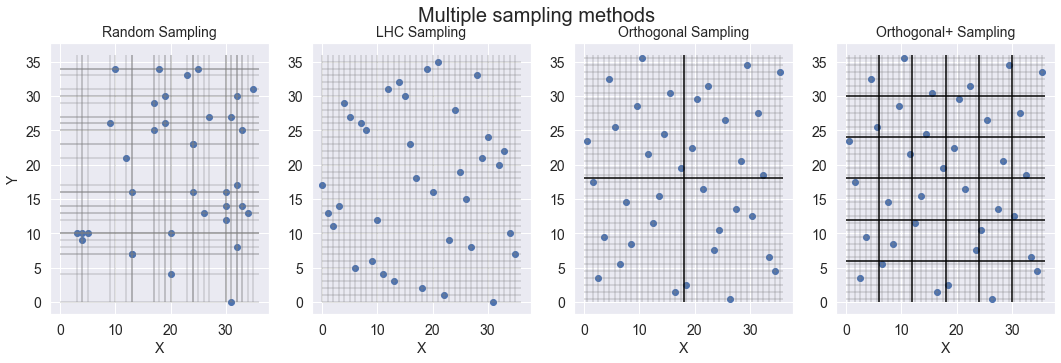

In [18]:
import matplotlib.pyplot as plt

# Creating orthogonal sampling
x = np.arange(0, 36, 1)
y = np.arange(0, 36, 1)
stepsize = int(np.sqrt(len(x)))
print(stepsize**2)

# empty lists for saving
x_choices = []
y_choices = []

# Keep track of choices
x_masked = np.ones(len(x), dtype='bool')
y_masked = np.ones(len(y), dtype='bool')

# Loop over rows and columns
for i_y in range(0, len(x), stepsize):
    for i_x in range(0, len(x), stepsize):

        # Choice and remove
        x_choice = np.random.choice(np.arange(i_x, i_x + stepsize, 1)[x_masked[i_x: i_x + stepsize]])
        y_choice = np.random.choice(np.arange(i_y, i_y + stepsize, 1)[y_masked[i_y: i_y + stepsize]])

        # Keep track of x
        x_masked[x_choice] = False
        x_choices.append(x_choice)

        # Keep track of y
        y_masked[y_choice] = False
        y_choices.append(y_choice)

print("x_choices: ", x[x_choices])
print("y_choices: ", y[y_choices])

# Draw subplots for report
fig, axes = plt.subplots(1, 4, figsize=(18,5))

a_, b_ = np.random.choice(x, size=36), np.random.choice(y, size=36)
axes[0].scatter(a_, b_)
axes[0].hlines(b_, 0, 36, alpha=0.3, color='grey')
axes[0].vlines(a_, 0, 36, alpha=0.3, color='grey')
axes[0].set_title('Random Sampling', fontsize=14)

a_, b_ = np.random.choice(x, size=36, replace=False), np.random.choice(y, size=36, replace=False)
axes[1].scatter(a_, b_)
axes[1].hlines(b_, 0, 36, alpha=0.3, color='grey')
axes[1].vlines(a_, 0, 36, alpha=0.3, color='grey')
axes[1].set_title('LHC Sampling', fontsize=14)

a_ = np.array(x[x_choices]) + 0.5
b_  = np.array(y[y_choices]) + 0.5
axes[2].scatter(a_, b_)
axes[2].hlines(b_, 0, 36, alpha=0.3, color='grey')
axes[2].vlines(a_, 0, 36, alpha=0.3, color='grey')
axes[2].hlines([18], xmin=0, xmax=36, color='black')
axes[2].vlines([18], ymin=0, ymax=36, color='black')
axes[2].set_title('Orthogonal Sampling', fontsize=14)

a_ = np.array(x[x_choices]) + 0.5
b_  = np.array(y[y_choices]) + 0.5
axes[3].scatter(a_, b_)
axes[3].hlines(b_, 0, 36, alpha=0.3, color='grey')
axes[3].vlines(a_, 0, 36, alpha=0.3, color='grey')
axes[3].hlines([6, 12, 18, 24, 30], xmin=0, xmax=36, color='black')
axes[3].vlines([6, 12, 18, 24, 30], ymin=0, ymax=36, color='black')
axes[3].set_title('Orthogonal+ Sampling', fontsize=14)

for i in range(len(axes)):
    axes[i].tick_params('both', labelsize=14)
    axes[i].set_xlabel('X', fontsize=14)
axes[0].set_ylabel('Y', fontsize=14)

fig.suptitle("Multiple sampling methods", fontsize=20)

Power_divergenceResult(statistic=16513677.744920162, pvalue=0.0)


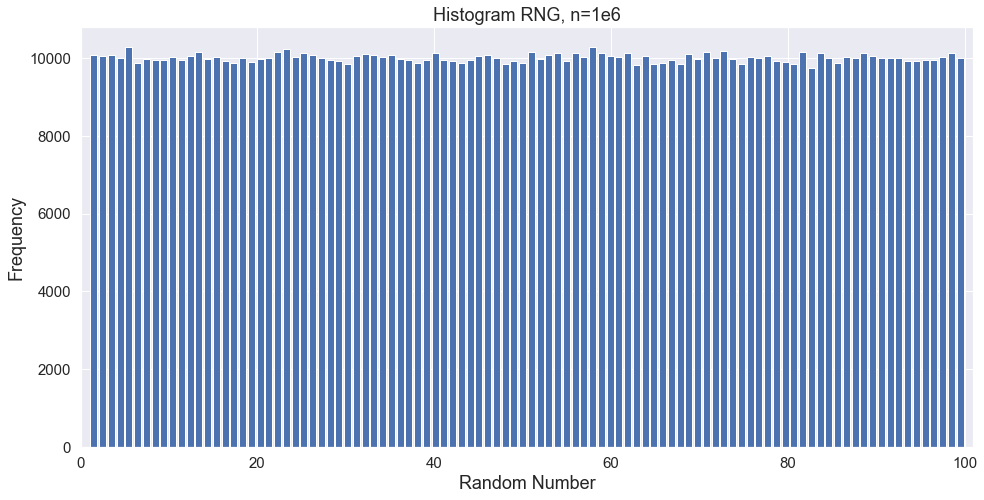

In [19]:
from scipy.stats import chisquare

# Draw simple figure for report
def test_RNG(n_list, n_rand):
    a = np.arange(1,n_list+1,1)
    # print(a)

    b = np.random.choice(a, size=n_rand)

    fig, ax = plt.subplots(figsize=(16,8))
    plt.hist(b, bins=n_list, rwidth=0.8)
    plt.title(f"Histogram RNG, n=1e6", fontsize=18)
    plt.xlabel("Random Number", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.subplots_adjust(bottom=0.15)
    plt.xlim(0,101)
    plt.savefig("rngtest.png", dpi=300)

    return chisquare(b)

n_list = 100
n_rand = int(1e6)

_ = test_RNG(n_list, n_rand)
print(_)

# Intelligent Stratified Sampling

The implementation of intelligent stratified sampling


In [20]:
def new_grid_conds(xi, yi):
    """
    Checks if datapoint lies within intelligent sample space.

    args:
        xi: (Float)   Total N samples given to check for convergence
        yi: (Float)   Maximum amount of iterations to check for convergence
        
    
    returns:
        Bool: (Bool)
    """
    
    if 1 < yi <= 1.5:
        if not  -0.5 <= xi <= 0:
            return False
        else:
            return True
    elif 0.5 < yi <= 1:
        if not -1 <= xi <= 0.5:
            return False
        else:
            return True
    elif 0 <= yi <= 0.5:
        if not -2 <= xi <= 0.5:
            return False
        else: 
            return True

def new_grid(x_grid, y_grid):
    """
    Creates intelligent grid.

    args:
        x_grid: (1D array)  NumPy array with original x coordinates 
        y_grid: (1D array   NumPy array with original y coordinates 
        
    
    returns:
        new_x_grid: (1D array) NumPy array with new x coordinates
        new_y_grid: (1D array) NumPy array with new y coordinates
    """
    
    new_x_grid = []
    new_y_grid = []
    
    # loop through old grid
    for xi in x_grid:
        for yi in y_grid:
            
            # if value in new grid, append to new grid list
            if new_grid_conds(xi,yi):
                new_x_grid.append(xi)
                new_y_grid.append(yi)
                
    return new_x_grid, new_y_grid
    
def iterate2(complex_number, max_iterations):
    """
    Method to iterate using complex numbers;

    args:
        complex_number: (Complex) Complex number
        max_iterations: (Int)     Max iterations to check for convergence

    returns:
        interations:    (Int)     Amount of iterations done for divergence
    """
    zn = 0
    for i in range(max_iterations):
        if abs(zn) > 2:
            break
        zn = zn**2 + complex_number
    return i + 1

def monte_carlo2(samples, max_iterations, area_rect):
    """
    Performs the monte carlo simulation.

    args:
        samples:        (Int)   Total N samples given to check for convergence
        max_iterations: (Int)   Maximum amount of iterations to check for convergence
        area_rect:      (Int)   Total area 
      
    returns:
        area_estimation (Float) Estimation of the mandelbrot area
    """
    
    # the random samples
    x_samp = samples[0]
    y_samp = samples[1]
    
    # counters
    Inner = 0
    Outer = 0
    
    # loop through random samples
    for i in range(len(x_samp)):
            # create complex number
            complex_number = complex(x_samp[i], y_samp[i])
            
            # iterate mandelbrot until divergence or until max iterations is reached
            iters = iterate2(complex_number, max_iterations)
            
            # if max iteration is reached (no divergence)
            if iters == max_iterations:
                Inner += 1
            
            # if divergence
            else:
                Outer +=1

    # calculate estimated area            
    area_est = area_rect * Inner/(Inner+Outer)
    
    return area_est

def random_samples(x, y, n_sample):
    """
    Returns a random n-size batch of lists x and y (uniform)
    
    args:
        x:      (1D array) Array with possible x values to sample from.
        y:      (1D array) Array with possible y values to sample from.
        n_sample:      (Int)      Amount to be sampled.
       

    returns:
        samples (Tuple) A tuple of N * x samples and N * y samples. 
                        Being a total of N coordinates.

    """
    
    x_samp = np.random.choice(x, size=n_sample, replace=True)
    y_samp = np.random.choice(y, size=n_sample, replace=True)

    
    return x_samp, y_samp

def LHC_samples(x, y, n_sample):
    """
    Returns a random n-size batch of lists x and y based on LHC sampling
    
    args:
        x:      (1D array) Array with possible x values to sample from.
        y:      (1D array) Array with possible y values to sample from.
        n_sample:      (Int)      Amount to be sampled.
       

    returns:
        samples (Tuple) A tuple of N * x samples and N * y samples. 
                        Being a total of N coordinates.

    """
    
    x_samp = np.random.choice(x, size=n_sample, replace=False)
    y_samp = np.random.choice(y, size=n_sample, replace=False)

    
    return x_samp, y_samp

def new_rand(x, y, s, LHC=False):
    """ 
        Method to RANDOM sample the created grid, specifically for Intelligent Stratfied
        Sampling.

        args:
            x:      (1D array) Array with possible x values to sample from.
            y:      (1D array) Array with possible y values to sample from.
            s:      (Int)      Amount to be sampled.
            LHC:    (Bool)     Whether Latin Hypercube Sampling is used.
            
        returns:
            samples (Tuple) A tuple of N * x samples and N * y samples. 
                            Being a total of N coordinates.
    """
     # indexes of all samples
    choicelist = list(range(len(x)))

    # combine x and y arrays
    X = np.column_stack((x,y))

    # get indices of all sampled datapoints
    inds = np.random.choice(choicelist, size=s, replace=not(LHC))

    # obtain chosen samples
    X = X[inds]
    new_x = X[:,0]
    new_y = X[:,1]

    return [new_x, new_y]




# parameters
x = np.arange(-2, 1, 0.00099174)
y = np.arange(-1.5, 1.5, 0.00099174)

x_new,y_new = new_grid(x,y)

runs = 1000
boxplot = []
area_rect = 9
s = 3025
i = 100


samp_types = ["rand_samp", "b_rand_samp", "LHC", "b_LHC"]
for samp_type in samp_types:
    area_ests = []
    
    for run in trange(runs):
        if samp_type =="rand_samp":
            area_rect = 9
            samples =  random_samples(x, y, s) 
            
        elif samp_type == "b_rand_samp":
            area_rect = 4.5

            samples = new_rand(x_new, y_new, s, LHC=False) 

        elif samp_type == "LHC":
            area_rect = 9
            
            samples =  LHC_samples(x, y, s) 
            
        else:
            area_rect = 4.5
            
            samples = new_rand(x_new, y_new, s, LHC=True) 
            
            
      
        # calculate area
        area_est = monte_carlo2(samples, i, area_rect) 
        area_ests.append(area_est)
        
       
    boxplot.append(area_ests)
    
# plot boxplot
plt.show()
plt.boxplot(boxplot) 
plt.title("Intelligent Stratified Sampling")
plt.xlabel("Sampling methods")
plt.ylabel('Estiamted area')
plt.xticks([1,2,3,4], ["Random", "Intelligent Random", "LHC", "Intelligent LHC"])
plt.show()       


NameError: name 'new_grid' is not defined